<a href="https://colab.research.google.com/github/foxtrotmike/ALBRT/blob/main/SAIL_completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Spatial Autocorrelation: A Differentiable and Learnable Extension of Moran's I

(Fayyaz Minhas)

## 1. Introduction

Spatial autocorrelation measures the degree to which observations that are close in space exhibit similar values. Classical statistics, such as Moran’s I, have long served as foundational tools for spatial analysis in ecology, geostatistics, and medical imaging. However, these classical indices are **non-differentiable**, **manually parameterized**, and **not suited for modern deep learning workflows**.

We propose the **Spatial Autocorrelation Index Layer (SAIL)**, a novel neural network module that generalizes **Moran’s I** to a fully differentiable, learnable, and **multi-headed attention-based** architecture. SAIL is capable of computing both **local** and **global** autocorrelation scores from arbitrary spatial graphs, and supports **multi-head projections** to discover and aggregate multiple latent spatial patterns. It supports gradient-based learning, can be used for spatial classification, and enables the discovery of **orthogonal directions of maximal spatial autocorrelation**.

We provide a full **matrix-based derivation** of SAIL and demonstrate its effectiveness in three use cases:  
1. Recovering classical Moran's I structure in synthetic graphs,  
2. Enhancing classification of spatially coherent vs. incoherent patterns,  
3. Learning orthogonal projections that maximize spatial autocorrelation.

---

## 2. Background: Moran's I and Its Limitations

Let $z \in \mathbb{R}^n$ be a vector of scalar observations at spatial locations $\{x_i\}_{i=1}^n$. The **classical global Moran’s I** is defined as:

$$
I = \frac{n}{\sum_{i,j} w_{ij}} \cdot \frac{ \sum_{i,j} w_{ij}(z_i - \bar{z})(z_j - \bar{z}) }{ \sum_i (z_i - \bar{z})^2 }
$$

where $w_{ij} \geq 0$ denotes spatial weights (e.g., based on distance or graph connectivity), and $\bar{z}$ is the mean of $z$.

A **local version** of Moran’s I at node $i$ is:

$$
I_i^{\text{local}} = \frac{(z_i - \bar{z})}{\sigma^2} \sum_{j} w_{ij}(z_j - \bar{z})
$$

These indices rely on fixed spatial kernels and do not support differentiable or learnable extensions.

---

## 3. The Spatial Autocorrelation Index Layer (SAIL)

SAIL generalizes Moran’s I by introducing a **learnable attention mechanism** that replaces fixed weights with differentiable similarity kernels over node features and coordinates. Additionally, **multi-headed SAIL** extends this formulation by using **multiple feature projections**, each associated with a separate attention kernel and autocorrelation computation.

### 3.1 Input and Feature Projection

Given node features $X \in \mathbb{R}^{n \times d}$ and spatial coordinates $C \in \mathbb{R}^{n \times 2}$, each SAIL head $h$ applies a learnable scalar projection $f^{(h)}: \mathbb{R}^d \to \mathbb{R}$:

$$
z^{(h)} = f^{(h)}(X), \quad \tilde{z}^{(h)} = \frac{z^{(h)} - \bar{z}^{(h)}}{\sqrt{\frac{1}{n} \sum_i (z^{(h)}_i - \bar{z}^{(h)})^2 + \varepsilon}}
$$

The multi-head design allows the model to learn **diverse spatial embeddings** from the same feature space.

### 3.2 Learnable Spatial Weights (Per Head)

For each head $h$, we define the soft attention matrix $A^{(h)} \in \mathbb{R}^{n \times n}$ as:

$$
A^{(h)}_{ij} = \frac{ \exp\left( -\left( \theta^{(h)}(X_i, X_j) + T^{(h)} \cdot D_{ij} \right) \right)}{ \sum_k \exp\left( -\left( \theta^{(h)}(X_i, X_k) + T^{(h)} \cdot D_{ik} \right) \right) }
$$

where:
- $\theta^{(h)}$ is a learnable dissimilarity function for head $h$ (e.g., MLP),
- $D_{ij} = \|C_i - C_j\|^2$ is the squared spatial distance,
- $T^{(h)}$ is a head-specific learnable temperature.

This head-wise design enables each projection to learn a distinct neighborhood structure and spatial attention.

### 3.3 Local and Global SAIL Outputs (Multi-Headed)

For each head $h$, we compute the local Moran’s I vector and global Moran’s I scalar:

$$
I^{(h)}_{\text{local}} = \tilde{z}^{(h)} \odot \left( A^{(h)} \tilde{z}^{(h)} \right), \quad
I^{(h)}_{\text{global}} = \frac{1}{n} \sum_{i=1}^n I^{(h)}_i = \frac{1}{n} \tilde{z}^{(h)\top} A^{(h)} \tilde{z}^{(h)}
$$

The **multi-head output** is a vector of size $k$, where $k$ is the number of heads:

$$
I_{\text{global}} = \left[ I^{(1)}_{\text{global}}, \ldots, I^{(k)}_{\text{global}} \right]^\top \in \mathbb{R}^k
$$

This vector can be used directly as input to downstream models such as classifiers or regressors.

---

## 4. Learning Maximal Autocorrelation Directions

To identify spatially meaningful embeddings, we seek **multiple orthogonal directions** in feature space that independently maximize spatial autocorrelation.

Given $X \in \mathbb{R}^{n \times d}$ and $W = [w_1, \ldots, w_k] \in \mathbb{R}^{d \times k}$, we define projections $z_j = X w_j$, normalized as:

$$
\tilde{z}_j = \frac{z_j - \bar{z}_j}{\sqrt{\frac{1}{n} \sum_i (z_{ji} - \bar{z}_j)^2 + \varepsilon}}
$$

We then solve:

$$
\max_{W \in \mathbb{R}^{d \times k}, \, W^\top W = I} \quad \sum_{j=1}^k \frac{1}{n} \tilde{z}_j^\top A_j \tilde{z}_j
$$

where each $A_j$ is an attention matrix computed using a shared or fixed $\theta$ and $T$.

This is analogous to PCA, but with the objective of maximizing **spatial coherence** rather than variance. We use QR re-orthogonalization during training to maintain orthogonality of directions.

---

## 5. Experiments

### 5.1 Synthetic Graphs

We validate SAIL on three canonical graph types:
- **Random Graph**: no structure $\Rightarrow I \approx 0$,
- **Gradient Graph**: spatially smooth features $\Rightarrow I \approx 1$,
- **Checkerboard Graph**: alternating spatial pattern $\Rightarrow I \approx -1$.

### 5.2 Spatial Graph Classification

We construct a dataset where class 1 graphs have spatially coherent features, while class 0 graphs have the same features but spatially permuted coordinates. A classifier composed of **multi-headed SAIL** followed by an MLP achieves high accuracy, exploiting spatial structure in ways that feature-only models cannot.

### 5.3 Discovering Spatial Directions

Using the orthogonal projection version of multi-headed SAIL, we learn a set of spatially diverse directions in feature space that maximize global Moran’s I. Visualizations show that each direction highlights a distinct spatial mode, making this technique useful for exploratory spatial analysis and interpretable embeddings.

---

## 6. Conclusion

We present SAIL, a learnable, differentiable, and multi-headed extension of Moran’s I for graph-structured spatial data. By replacing static spatial kernels with neural attention mechanisms, and enabling multi-directional spatial reasoning via multiple heads, SAIL opens new possibilities for spatially-aware learning in classification, representation learning, and unsupervised discovery. Future work includes extending SAIL to dynamic graphs and temporal-spatial reasoning.


### Imports and Device Setup

In [1]:
!pip install torch-geometric
# === Essential Imports ===
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.data import Data, Batch
from mpl_toolkits.axes_grid1 import make_axes_locatable

# === Set device (GPU if available) ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## SAIL Layer

In [2]:
# === Spatial Autocorrelation Index Layer ===
class SpatialAutocorrelationIndexLayer(nn.Module):
    """
    Differentiable generalization of Moran's I using attention over spatial graphs.
    Computes both local and global spatial autocorrelation.
    """
    def __init__(self, f_map, f_theta, num_heads=1, eps=1e-6,
                 temperature=5.0, learnable_temperature=False,
                 dfun=torch.cdist, use_edges=False, allow_self_loops=False):
        super().__init__()
        self.num_heads = num_heads
        self.eps = eps
        self.dfun = dfun
        self.use_edges = use_edges
        self.allow_self_loops = allow_self_loops

        # Projection functions (phi) and dissimilarities (theta)
        self.f_maps = nn.ModuleList(f_map if isinstance(f_map, (list, nn.ModuleList))
                                    else [copy.deepcopy(f_map) for _ in range(num_heads)])
        self.f_thetas = nn.ModuleList([copy.deepcopy(f_theta) for _ in range(num_heads)])

        # Temperature controls softmax sharpness
        temp_tensor = torch.tensor(temperature, dtype=torch.float32)
        if learnable_temperature:
            self.temperatures = nn.ParameterList([
                nn.Parameter(temp_tensor.clone()) for _ in range(num_heads)
            ])
        else:
            self.register_buffer("temperatures", torch.stack([temp_tensor.clone()] * num_heads))

    def forward(self, batch: Batch, return_local=False, return_attention=False):
        """
        Computes global Moran's I (optionally local scores and attention maps).
        """
        graphs = batch.to_data_list()
        global_I_all, local_I_all, attention_all = [], [], []

        for data in graphs:
            x, coords = data.x, data.coords
            n = x.size(0)
            D2 = self.dfun(coords, coords)

            # Attention mask: edges or full graph
            mask = torch.zeros((n, n), dtype=torch.bool, device=x.device)
            if self.use_edges and hasattr(data, 'edge_index'):
                row, col = data.edge_index
                mask[row, col] = True
            else:
                mask[:, :] = True
                if not self.allow_self_loops:
                    mask.fill_diagonal_(False)

            per_head_global_I, per_head_local_I, per_head_attention = [], [], []

            for h in range(self.num_heads):
                # Normalize scalar projection
                z = self.f_maps[h](x).squeeze(-1)
                mu_z = z.mean()
                z_centered = z - mu_z
                var_z = z_centered.pow(2).mean() + self.eps
                z_norm = z_centered / var_z.sqrt()

                # Compute attention logits
                theta_ij = self.f_thetas[h](x, x)
                T = self.temperatures[h]
                logits = -(theta_ij + D2 * T)
                logits[~mask] = float('-inf')
                a_ij = F.softmax(logits, dim=1)

                # Compute local and global Moran's I
                z_agg = torch.matmul(a_ij, z_norm)
                local_I = z_norm * z_agg
                global_I = local_I.mean()
                per_head_global_I.append(global_I)

                if return_local:
                    per_head_local_I.append(local_I.unsqueeze(1))
                if return_attention:
                    per_head_attention.append(a_ij.unsqueeze(0))

            global_I_all.append(torch.stack(per_head_global_I))
            if return_local:
                local_I_all.append(torch.cat(per_head_local_I, dim=1))
            if return_attention:
                attention_all.append(torch.cat(per_head_attention, dim=0))

        global_I_all = torch.stack(global_I_all)

        if return_local and return_attention:
            return global_I_all, local_I_all, attention_all
        elif return_local:
            return global_I_all, local_I_all
        elif return_attention:
            return global_I_all, attention_all
        else:
            return global_I_all


## Feature Maps and Dissimilarity Modules

In [3]:
# === Simple projection: select one feature ===
class SingleFeature(nn.Module):
    def __init__(self, feature_index=0):
        super().__init__()
        self.feature_index = feature_index

    def forward(self, x):
        return x[:, self.feature_index].unsqueeze(-1)

# === Fixed theta: constant dissimilarity ===
class FixedTheta(nn.Module):
    def __init__(self, theta: float):
        super().__init__()
        self.theta = theta

    def forward(self, x_i, x_j):
        n = x_i.size(0)
        return torch.full((n, n), self.theta, device=x_i.device)


## Dummy Graph + Utilities for Batching

In [4]:
# === Minimal graph abstraction ===
class DummyGraph:
    def __init__(self, x, coords, edge_index=None):
        self.x = x.to(device)
        self.coords = coords.to(device)
        self.edge_index = edge_index.to(device) if edge_index is not None else None

    def to(self, device):
        self.x = self.x.to(device)
        self.coords = self.coords.to(device)
        if self.edge_index is not None:
            self.edge_index = self.edge_index.to(device)
        return self

# === Convert DummyGraph → PyG Data object ===
def convert_dummy_to_pyg(data):
    data_pyg = Data(x=data.x, coords=data.coords)
    if data.edge_index is not None:
        data_pyg.edge_index = data.edge_index
    return data_pyg

# === Batch a list of DummyGraph into PyG Batch ===
def build_batch(graphs: list) -> Batch:
    return Batch.from_data_list([convert_dummy_to_pyg(g) for g in graphs])


## Synthetic Data Generators

In [5]:
# === Random spatial graph ===
def generate_random_graph(n=100, d=1):
    x = torch.rand(n, d, device=device)
    coords = torch.rand(n, 2, device=device)
    edge_index = torch.combinations(torch.arange(n, device=device), r=2).T
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
    return DummyGraph(x, coords, edge_index)

# === Spatially smooth graph (high Moran's I) ===
def generate_high_moran_graph(grid_size=16, noise=0.0):
    x_coords = torch.linspace(0, 1, grid_size, device=device)
    y_coords = torch.linspace(0, 1, grid_size, device=device)
    xv, yv = torch.meshgrid(x_coords, y_coords)
    coords = torch.stack([xv.flatten(), yv.flatten()], dim=1)
    features = (coords[:, 0] + coords[:, 1]).unsqueeze(1)
    features += noise * torch.randn_like(features)

    def node_index(i, j): return i * grid_size + j
    edges = []
    for i in range(grid_size):
        for j in range(grid_size):
            current = node_index(i, j)
            for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < grid_size and 0 <= nj < grid_size:
                    edges.append((current, node_index(ni, nj)))
    edge_index = torch.tensor(edges + [(j, i) for i, j in edges], dtype=torch.long, device=device).t().contiguous()
    return DummyGraph(features, coords, edge_index)

# === Checkerboard graph (negative Moran's I) ===
def generate_checker_moran_graph(grid_size=16):
    indices = torch.arange(grid_size, device=device)
    xx, yy = torch.meshgrid(indices, indices)
    checker = ((xx + yy) % 2).float().flatten().unsqueeze(1)
    checker -= checker.mean()
    coords = torch.stack(torch.meshgrid(
        torch.linspace(0, 1, grid_size, device=device),
        torch.linspace(0, 1, grid_size, device=device)
    ), dim=-1).reshape(-1, 2)

    def idx(i, j): return i * grid_size + j
    edges = []
    for i in range(grid_size):
        for j in range(grid_size):
            curr = idx(i, j)
            for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
                if 0 <= ni < grid_size and 0 <= nj < grid_size:
                    neigh = idx(ni, nj)
                    edges.append((curr, neigh))
                    edges.append((neigh, curr))
    edge_index = torch.tensor(edges, dtype=torch.long, device=device).t().contiguous()
    return DummyGraph(checker, coords, edge_index)


## Visualization Code

In [6]:
# === Visualize node features + local Moran's I + attention edges ===
def visualize_dual_colormap_graph_with_attention(
    graph, phi_values, local_moran, A=None, threshold=0.1,
    title="Local Moran's I + Feature Map + Attention Weights",
    feature_label="Feature Value φ(x)", moran_label="Local Moran's I",
    inner_cmap="viridis", outer_cmap="bwr"
):
    coords = graph.coords.detach().cpu().numpy()
    phi_values = phi_values.detach().cpu().numpy()
    local_moran = local_moran.detach().cpu().numpy()

    fig, ax = plt.subplots(figsize=(8, 8))

    # Outer color: local Moran's I
    sc_outer = ax.scatter(coords[:, 0], coords[:, 1], s=800, c=local_moran,
                          cmap=outer_cmap, vmin=-1, vmax=1, edgecolors="none", zorder=1)

    # Inner color: projection φ(x)
    sc_inner = ax.scatter(coords[:, 0], coords[:, 1], s=300, c=phi_values,
                          cmap=inner_cmap, edgecolors="black", linewidths=0.2, zorder=2)

    # Attention arrows
    if A is not None:
        A_np = A.detach().cpu().numpy()
        n = A_np.shape[0]
        for i in range(n):
            for j in range(n):
                attn_weight = A_np[i, j]
                if attn_weight > threshold:
                    start, end = coords[i], coords[j]
                    dx, dy = end[0] - start[0], end[1] - start[1]
                    norm = np.sqrt(dx**2 + dy**2)
                    if norm == 0:
                        continue
                    dx *= 0.95
                    dy *= 0.95
                    ax.arrow(
                        start[0], start[1], dx, dy,
                        head_width=0.015, head_length=0.02,
                        fc='gray', ec='gray', alpha=0.6,
                        linewidth=5 * attn_weight, length_includes_head=True, zorder=0
                    )

    ax.set_title(title, fontsize=14)
    ax.set_aspect("equal")
    ax.axis("off")

    divider = make_axes_locatable(ax)
    cax_left = divider.append_axes("left", size="5%", pad=0.1)
    cax_right = divider.append_axes("right", size="5%", pad=0.1)
    cbar_outer = fig.colorbar(sc_outer, cax=cax_left)
    cbar_outer.set_label(moran_label, fontsize=10)
    cbar_inner = fig.colorbar(sc_inner, cax=cax_right)
    cbar_inner.set_label(feature_label, fontsize=10)
    cax_left.yaxis.set_ticks_position('left')
    cax_left.yaxis.set_label_position('left')
    plt.tight_layout()
    plt.show()

# === Visualize SAIL layer outputs on a single graph ===
def viz_sail(sail, viz_graph, head_idx=0, title=""):
    with torch.no_grad():
        batch = build_batch([viz_graph])
        z = sail.f_maps[head_idx](viz_graph.x).squeeze(-1)
        global_I, local_I, attention = sail(batch, return_local=True, return_attention=True)
        local_I = local_I[0][:, head_idx]
        A = attention[0][head_idx]

    title += f" : Head {head_idx}"
    visualize_dual_colormap_graph_with_attention(
        viz_graph, phi_values=z, local_moran=local_I, A=A, title=title
    )


## Experiment 1: Evaluation on Synthetic Graphs

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[Random Graph] Moran's I: -0.0228
[High Moran Graph] Moran's I: 0.9844
[Checkerboard Graph] Moran's I: -1.0000


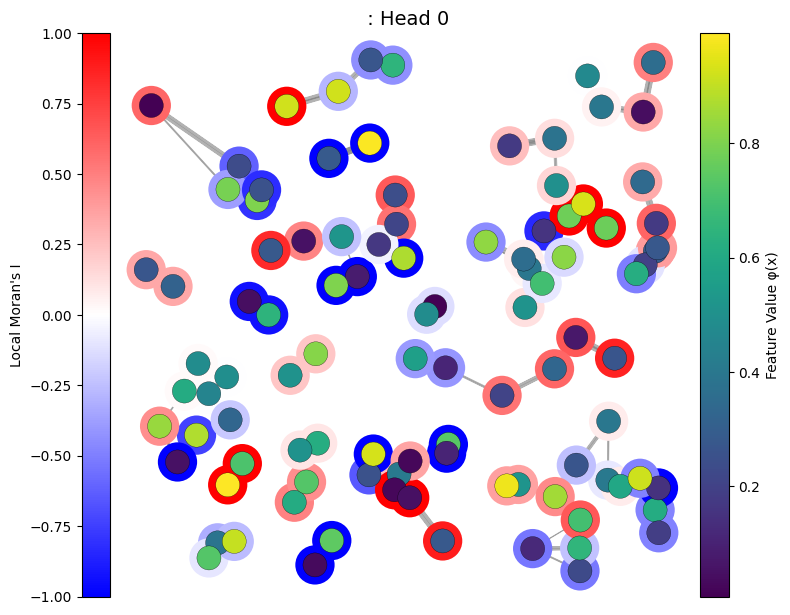

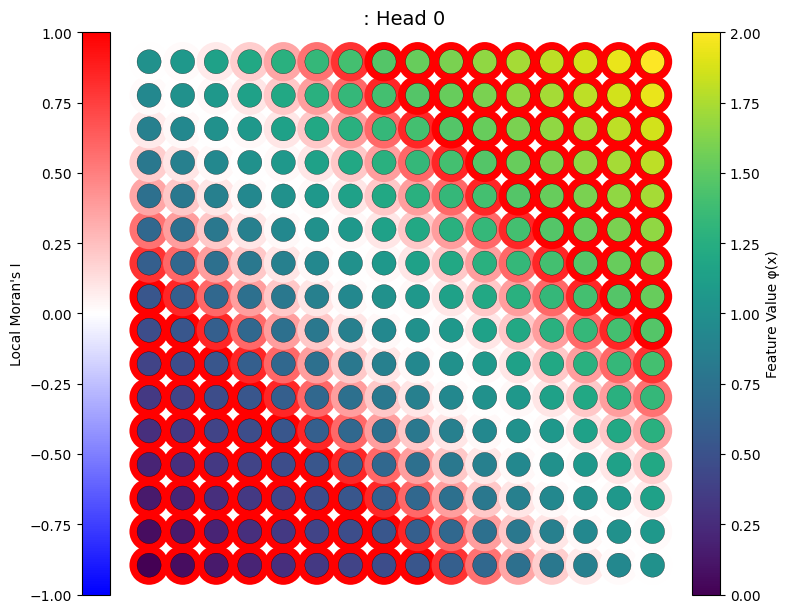

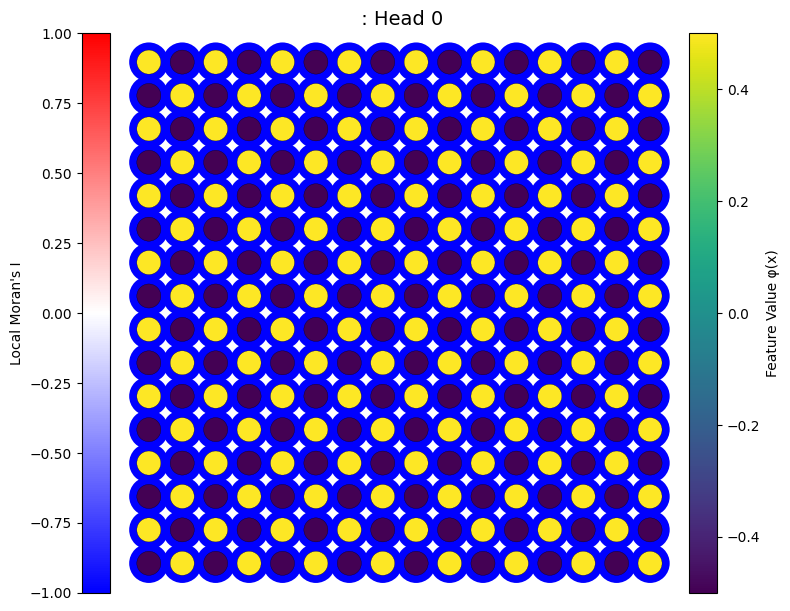

In [7]:
# === Evaluate SAIL on benchmark synthetic graphs ===
torch.manual_seed(42)

f_map = SingleFeature(feature_index=0)
f_theta = FixedTheta(theta=1.0)
layer = SpatialAutocorrelationIndexLayer(
    f_map=f_map,
    f_theta=f_theta,
    num_heads=1,
    temperature=100.0,
    learnable_temperature=False,
    use_edges=True,
    allow_self_loops=False
).to(device)

# Generate example graphs
rand_graph = generate_random_graph()
hi_graph = generate_high_moran_graph()
checker_graph = generate_checker_moran_graph()

# Compute global Moran's I for each
with torch.no_grad():
    for name, g in [("Random", rand_graph), ("High Moran", hi_graph), ("Checkerboard", checker_graph)]:
        batch = build_batch([g])
        global_I = layer(batch).squeeze().item()
        print(f"[{name} Graph] Moran's I: {global_I:.4f}")

# Visualize attention, feature, and local I on one of them
viz_sail(layer, rand_graph)
viz_sail(layer, hi_graph)
viz_sail(layer, checker_graph)

## Experiment 2: Classification with SAIL

### Definition of Feature Maps

In [8]:
# === Learnable dissimilarity θ(x_i, x_j) ===
class LearnableTheta(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.linear = nn.Linear(2 * in_dim, 1)

    def forward(self, x_i, x_j):
        n = x_i.size(0)
        x_i_exp = x_i.unsqueeze(1).expand(n, n, -1)
        x_j_exp = x_j.unsqueeze(0).expand(n, n, -1)
        x_cat = torch.cat([x_i_exp, x_j_exp], dim=-1)
        return F.softplus(self.linear(x_cat).squeeze(-1))

# === Simple learnable linear projection φ(x) ===
class LinearFeatureMap(nn.Module):
    def __init__(self, in_dim=3):
        super().__init__()
        self.linear = nn.Sequential(nn.Linear(in_dim, 1), nn.Identity())

    def forward(self, x):
        return self.linear(x)


### Synthetic Data with Spatially Coherent vs. Random Graphs

In [9]:
import random
from torch.utils.data import Dataset

# === Graph with spatially meaningful or permuted features ===
class DummyGraph:
    def __init__(self, x, coords, label, edge_index = None):
        self.x = x.to(device)
        self.coords = coords.to(device)
        self.label = label
        self.edge_index = edge_index.to(device) if edge_index is not None else None

# === Binary classification dataset ===
class RealisticGraphDataset(Dataset):
    def __init__(self, num_graphs=100, min_nodes=20, max_nodes=50, noise=0.3):
        self.graphs = []
        for _ in range(num_graphs):
            label = random.choice([0, 1])
            self.graphs.append(self._make_graph(label, noise))

    def _make_graph(self, label, noise):
        n = random.randint(20, 50)
        coords = 2 * torch.rand(n, 2) - 1
        weights = 2 * torch.rand(2, 3) - 1
        base_features = coords @ weights + noise * torch.randn(n, 3)
        if label == 0:  # spatially permuted class
            coords = coords[torch.randperm(n)]
        return DummyGraph(x=base_features, coords=coords, label=label)

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]


### SAIL Classification Training Loop



In [10]:
# === Classification model using global Moran's I heads ===
class MoranClassifier(nn.Module):
    def __init__(self, sail: nn.Module, input_dim: int):
        super().__init__()
        self.sail = sail
        self.mlp = nn.Sequential(nn.Linear(input_dim, 2))  # binary classifier

    def forward(self, graph):
        pyg_data = Data(x=graph.x, coords=graph.coords)
        batch = Batch.from_data_list([pyg_data])
        global_I = self.sail(batch).squeeze(0)  # (num_heads,)
        return self.mlp(global_I)

# === Training helpers ===
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, correct = 0, 0
    for graph in dataloader:
        optimizer.zero_grad()
        out = model(graph)
        label = torch.tensor([graph.label], dtype=torch.long, device=device)
        loss = criterion(out.unsqueeze(0), label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (out.argmax() == label).item()
    return total_loss / len(dataloader), correct / len(dataloader)

def evaluate(model, dataloader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for graph in dataloader:
            out = model(graph)
            label = torch.tensor(graph.label, device=device)
            correct += (out.argmax() == label).item()
    return correct / len(dataloader)


### Training and Evaluation

Epoch 01 | Train Acc: 0.955 | Val Acc: 0.940
Epoch 02 | Train Acc: 0.978 | Val Acc: 1.000
Epoch 03 | Train Acc: 0.980 | Val Acc: 1.000
Epoch 04 | Train Acc: 0.985 | Val Acc: 1.000
Epoch 05 | Train Acc: 0.985 | Val Acc: 1.000
Epoch 06 | Train Acc: 0.983 | Val Acc: 0.980
Epoch 07 | Train Acc: 0.985 | Val Acc: 0.980
Epoch 08 | Train Acc: 0.985 | Val Acc: 0.980
Epoch 09 | Train Acc: 0.983 | Val Acc: 0.980


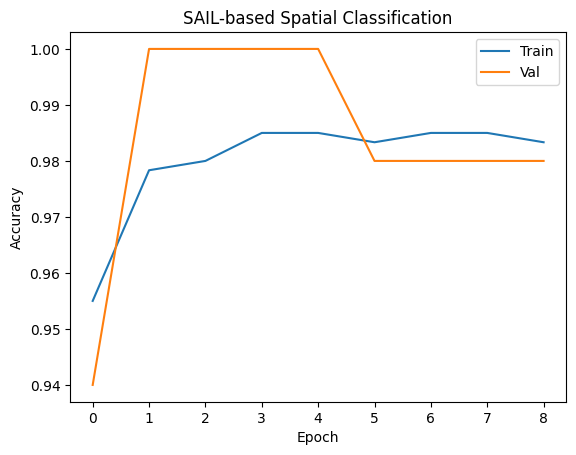

In [14]:
# === Initialize SAIL and classifier ===
num_heads = 2
sail = SpatialAutocorrelationIndexLayer(
    f_map=LinearFeatureMap(in_dim=3),
    f_theta=LearnableTheta(in_dim=3),
    num_heads=num_heads,
    use_edges=False,
    allow_self_loops=False,
    learnable_temperature=True
).to(device)

model = MoranClassifier(sail, input_dim=num_heads).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)
criterion = nn.CrossEntropyLoss()

# === Create train/val datasets ===
train_ds = RealisticGraphDataset(num_graphs=600)
val_ds = RealisticGraphDataset(num_graphs=50)

# === Train for a few epochs ===
train_accs, val_accs = [], []
for epoch in range(1, 10):
    #val_acc = evaluate(model, val_ds)
    train_loss, train_acc = train_epoch(model, train_ds, optimizer, criterion)
    val_acc = evaluate(model, val_ds)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch:02d} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")

# === Plot learning curve ===
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Val')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("SAIL-based Spatial Classification")
plt.legend()
plt.show()


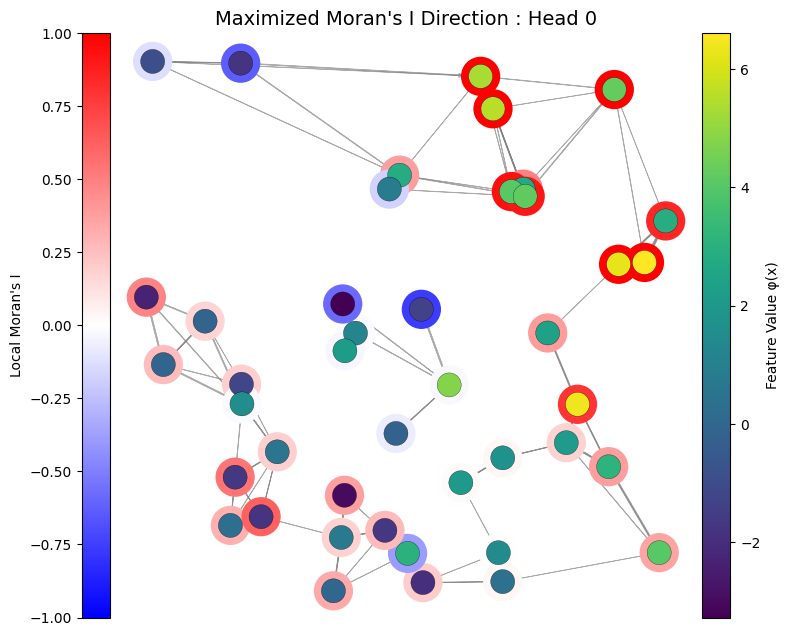

In [18]:
while True:
    raw_graph = random.choice(val_ds)
    if raw_graph.label == 1:
        break
viz_graph = DummyGraph(x=raw_graph.x.to(device), coords=raw_graph.coords.to(device), label=raw_graph.label)
viz_sail(sail, viz_graph, head_idx=0, title="Maximized Moran's I Direction")

## Discovering Orthogonal Spatial Directions of Maximal Autocorrelation with SAIL



In [12]:
# === Learnable shared orthogonal directions ===
class SharedOrthogonalDirections(nn.Module):
    def __init__(self, input_dim, k):
        super().__init__()
        self.W = nn.Parameter(torch.randn(input_dim, k))

    def orthonormalize(self):
        with torch.no_grad():
            Q, _ = torch.linalg.qr(self.W)
            self.W.copy_(Q)

    def make_head(self, idx):
        class HeadProjection(nn.Module):
            def __init__(self, parent, idx):
                super().__init__()
                self.parent = parent
                self.idx = idx
            def forward(self, x):
                w = self.parent.W[:, self.idx]
                z = x @ w
                return z.unsqueeze(-1)
        return HeadProjection(self, idx)
# === Shared learnable scalar temperature ===
class SharedTemperature(nn.Module):
    def __init__(self, init_temp: float, num_heads: int, learnable=True):
        super().__init__()
        temp = torch.tensor(init_temp, dtype=torch.float32)
        self.scalar = nn.Parameter(temp) if learnable else temp
        self.num_heads = num_heads

    def as_list(self):
        return nn.ParameterList([self.scalar for _ in range(self.num_heads)]) \
            if isinstance(self.scalar, nn.Parameter) else [self.scalar for _ in range(self.num_heads)]

# === Choose a graph and initialize multi-head SAIL ===
while True:
    raw_graph = random.choice(val_ds)
    if raw_graph.label == 1:
        break

viz_graph = DummyGraph(x=raw_graph.x.to(device), coords=raw_graph.coords.to(device), label=raw_graph.label)
k = 3
d = viz_graph.x.shape[1]
shared_f_map = SharedOrthogonalDirections(d, k)
f_theta = FixedTheta(theta=0.0)
f_maps = nn.ModuleList([shared_f_map.make_head(i) for i in range(k)])
shared_temp = SharedTemperature(init_temp=1.0, num_heads=k, learnable=True)

sail = SpatialAutocorrelationIndexLayer(
    f_map=f_maps,
    f_theta=f_theta,
    num_heads=k,
    temperature=shared_temp.scalar.item(),
    learnable_temperature=True,
    use_edges=False,
    allow_self_loops=False
).to(device)
sail.temperatures = shared_temp.as_list()

# === Optimize orthogonal projections to maximize Moran's I ===
optimizer = torch.optim.Adam(sail.parameters(), lr=0.1)
for epoch in range(5000):
    optimizer.zero_grad()
    batch = build_batch([viz_graph])
    global_I = sail(batch)  # shape (1, num_heads)
    loss = -global_I.mean()  # maximize Moran's I
    loss.backward()
    optimizer.step()
    shared_f_map.orthonormalize()
    if epoch % 500 == 0:
        print(f"[Epoch {epoch}] Moran's I: {-loss.item():.4f}")


[Epoch 0] Moran's I: 0.0539
[Epoch 500] Moran's I: 0.4228
[Epoch 1000] Moran's I: 0.4536
[Epoch 1500] Moran's I: 0.4676
[Epoch 2000] Moran's I: 0.4746
[Epoch 2500] Moran's I: 0.4783
[Epoch 3000] Moran's I: 0.4803
[Epoch 3500] Moran's I: 0.4815
[Epoch 4000] Moran's I: 0.4821
[Epoch 4500] Moran's I: 0.4879


1
[Final] Moran's I:  tensor([[0.7574, 0.5528, 0.1341]], device='cuda:0', grad_fn=<StackBackward0>)


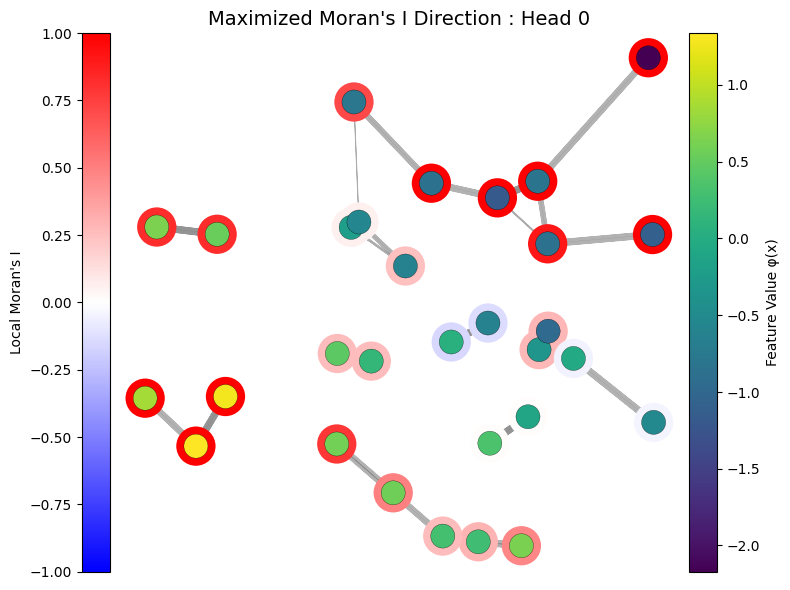

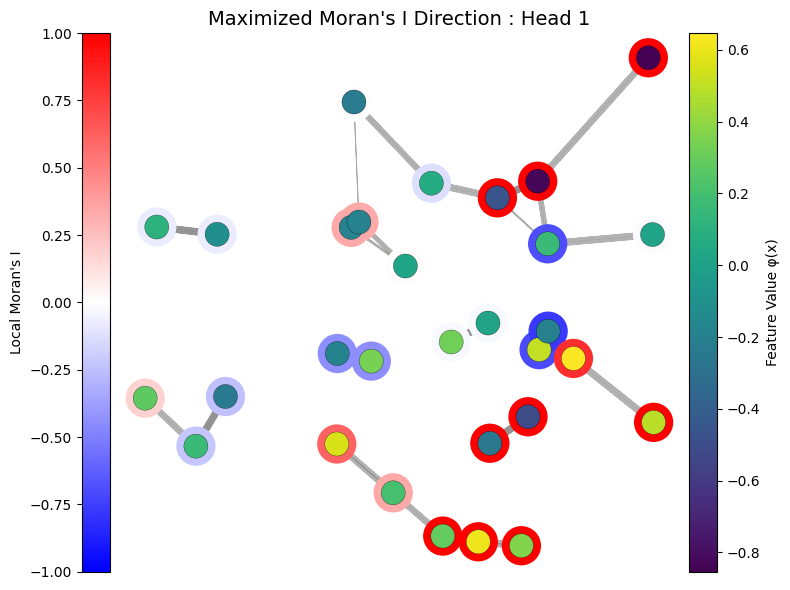

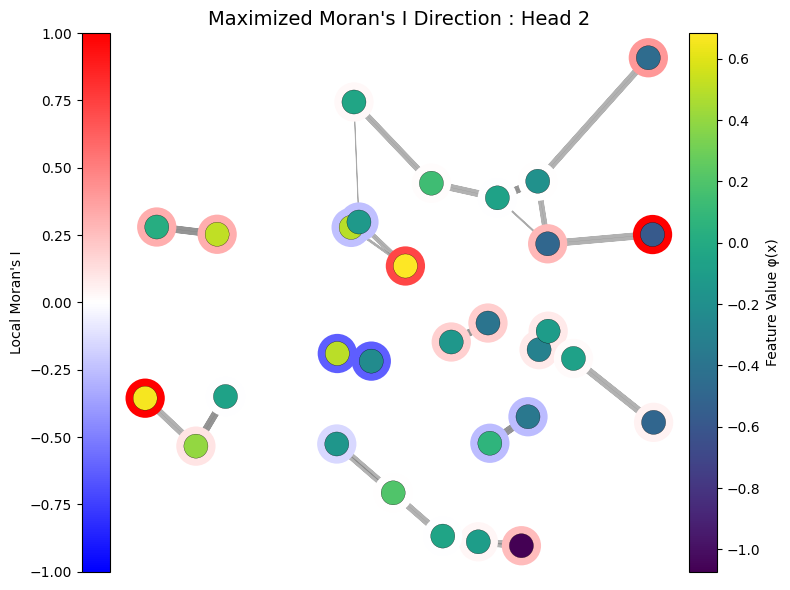

In [13]:
print(viz_graph.label)
print(f"[Final] Moran's I: ",global_I)
# === Visualize learned directions of maximal spatial autocorrelation ===
for i in range(k):
    viz_sail(sail, viz_graph, head_idx=i, title="Maximized Moran's I Direction")

